データのダウンロード

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Path to dataset files:", path)

100%|██████████| 2.84G/2.84G [00:29<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1


In [7]:
import shutil
import os

shutil.copytree(path, "/data")


# 元のパス
base_test_path = "/data/dataset/Test"
base_train_path = "/data/dataset/Train"
new_test_parent = os.path.join(base_test_path, "appletest")
new_train_parent = os.path.join(base_train_path, "appletrain")

# 新しいフォルダ appletest を作成
os.makedirs(new_test_parent, exist_ok=True)
os.makedirs(new_train_parent, exist_ok=True)

# 移動対象のフォルダ名
folders_to_move = ["freshapples", "rottenapples"]

# 各フォルダを appletest フォルダ内に移動
for folder in folders_to_move:
    test_src = os.path.join(base_test_path, folder)
    train_src = os.path.join(base_train_path, folder)
    test_dst = os.path.join(new_test_parent, folder)
    train_dst = os.path.join(new_train_parent, folder)
    if os.path.exists(test_src and train_src):
      shutil.move(test_src, test_dst)
      shutil.move(train_src, train_dst)




データの前処理の設定

In [8]:

import torchvision.transforms as transforms

resize = transforms.Resize((128,128)) #128*128
affine = transforms.RandomAffine([-15,15],scale=[0.8,1.2] ) #回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5) #左右反転
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize([0.0,0.0,0.0],[1.0,1.0,1.0]) #平均値0 標準偏差1

transforms_train = transforms.Compose([resize,affine,flip,to_tensor,normalize]) #トレーニングデータの設定
transforms_test = transforms.Compose([resize,to_tensor,normalize]) #テストデータの設定


データセットの読み込み

In [9]:
from torchvision import datasets

train_dir = "/data/dataset/Train/appletrain"
test_dir = "/data/dataset/Test/appletest"


train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transforms_train
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transforms_test
)



DataLoaderを作成

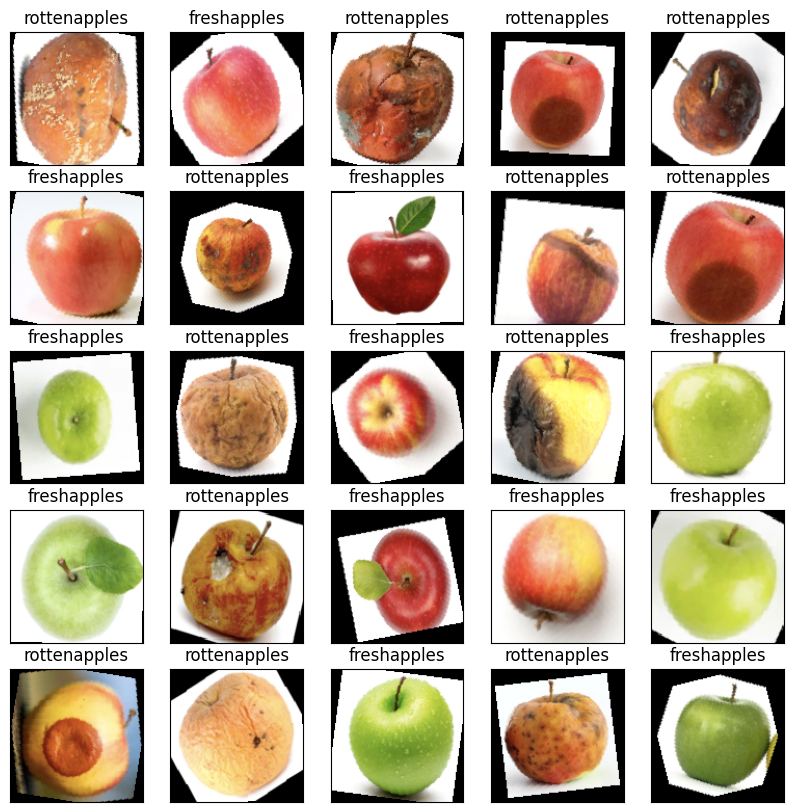

In [10]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False
    )


dataiter = iter(train_loader)
images,labels = next(dataiter)

classes = train_dataset.classes

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(np.transpose(images[i],(1,2,0)))
  label = classes[labels[i]]
  plt.title(label)
  plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

plt.show()

モデルの構築

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5) #124
    self.pool = nn.MaxPool2d(2,2) #72
    self.conv2 = nn.Conv2d(6,16,5) #68 34
    self.conv3 = nn.Conv2d(16,32,5) #30 15
    self.fc1 = nn.Linear(32*12*12,256)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(256,2)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1,32*12*12)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [12]:
from torch import optim

loss_fnc = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters())

record_loss_train = []
record_loss_test = []

x_test, t_test = next(iter(test_loader))
x_test, t_test = x_test.cuda(), t_test.cuda()

for i in range(20):
  net.train()
  loss_train = 0
  for j, (x, t) in enumerate(train_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    loss = loss_fnc(y, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)

  net.eval()
  y_test  = net(x_test)
  loss_test = loss_fnc(y_test,t_test).item()
  record_loss_test.append(loss_test)

  if i%1 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 0.6455293840236878 Loss_Test: 0.5611631870269775
Epoch: 1 Loss_Train: 0.3958396976918317 Loss_Test: 0.30572372674942017
Epoch: 2 Loss_Train: 0.2645515212684535 Loss_Test: 0.24601641297340393
Epoch: 3 Loss_Train: 0.17153998242502802 Loss_Test: 0.13700473308563232
Epoch: 4 Loss_Train: 0.1373481017778094 Loss_Test: 0.10059111565351486
Epoch: 5 Loss_Train: 0.11388731295807977 Loss_Test: 0.08866440504789352
Epoch: 6 Loss_Train: 0.11398328480760703 Loss_Test: 0.08834522217512131
Epoch: 7 Loss_Train: 0.0870289264686322 Loss_Test: 0.12406020611524582
Epoch: 8 Loss_Train: 0.09021161854518263 Loss_Test: 0.07306747883558273
Epoch: 9 Loss_Train: 0.06952729161954328 Loss_Test: 0.04882589355111122
Epoch: 10 Loss_Train: 0.06867955099749432 Loss_Test: 0.07964958250522614
Epoch: 11 Loss_Train: 0.05918278603218077 Loss_Test: 0.07549621164798737
Epoch: 12 Loss_Train: 0.06024986797462353 Loss_Test: 0.03864443302154541
Epoch: 13 Loss_Train: 0.05445741371806251 Loss_Test: 0.032909289002

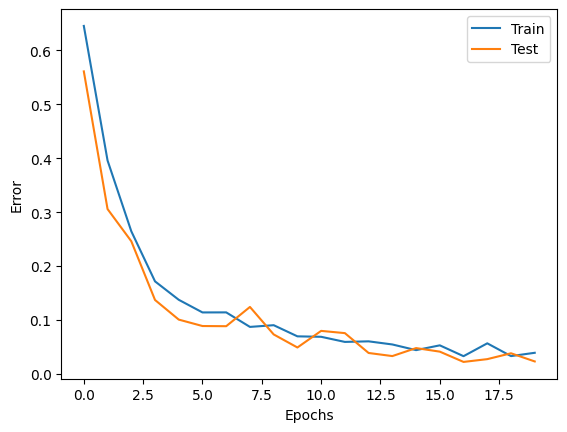

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [14]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 99.26925238898258%


In [15]:
import torch

for key in net.state_dict():
  print(key,":",net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0])

torch.save(net.state_dict(),"model_cnn.pth")

conv1.weight : torch.Size([6, 3, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
conv3.weight : torch.Size([32, 16, 5, 5])
conv3.bias : torch.Size([32])
fc1.weight : torch.Size([256, 4608])
fc1.bias : torch.Size([256])
fc2.weight : torch.Size([2, 256])
fc2.bias : torch.Size([2])
tensor([[[ 0.0435, -0.0717,  0.0699,  0.0159,  0.1087],
         [-0.0731,  0.0921,  0.1129, -0.0596,  0.1130],
         [ 0.1211, -0.0388,  0.0099,  0.1106, -0.0479],
         [-0.0163, -0.0094,  0.1125, -0.0558, -0.0548],
         [-0.0155, -0.0177,  0.1277,  0.0687,  0.1069]],

        [[ 0.0795, -0.0281, -0.0361, -0.0475,  0.0184],
         [-0.1386, -0.0152,  0.0085, -0.0824,  0.0117],
         [ 0.0818, -0.1159,  0.0036, -0.0095,  0.0206],
         [-0.0749, -0.0424,  0.0914,  0.0598, -0.1108],
         [-0.0323,  0.0953,  0.0462, -0.1109, -0.0623]],

        [[-0.0963, -0.0517,  0.0023, -0.0890, -0.0328],
         [ 0.0047, -0.0503, -0.0533, -0.0

In [16]:
net_loaded = Net()
net_loaded.load_state_dict(torch.load("model_cnn.pth",map_location=torch.device("cpu")))
net_loaded.eval()

for key in net_loaded.state_dict():
  print(key,":",net.state_dict()[key].size())
print(net_loaded.state_dict()["conv1.weight"][0])

conv1.weight : torch.Size([6, 3, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
conv3.weight : torch.Size([32, 16, 5, 5])
conv3.bias : torch.Size([32])
fc1.weight : torch.Size([256, 4608])
fc1.bias : torch.Size([256])
fc2.weight : torch.Size([2, 256])
fc2.bias : torch.Size([2])
tensor([[[ 0.0435, -0.0717,  0.0699,  0.0159,  0.1087],
         [-0.0731,  0.0921,  0.1129, -0.0596,  0.1130],
         [ 0.1211, -0.0388,  0.0099,  0.1106, -0.0479],
         [-0.0163, -0.0094,  0.1125, -0.0558, -0.0548],
         [-0.0155, -0.0177,  0.1277,  0.0687,  0.1069]],

        [[ 0.0795, -0.0281, -0.0361, -0.0475,  0.0184],
         [-0.1386, -0.0152,  0.0085, -0.0824,  0.0117],
         [ 0.0818, -0.1159,  0.0036, -0.0095,  0.0206],
         [-0.0749, -0.0424,  0.0914,  0.0598, -0.1108],
         [-0.0323,  0.0953,  0.0462, -0.1109, -0.0623]],

        [[-0.0963, -0.0517,  0.0023, -0.0890, -0.0328],
         [ 0.0047, -0.0503, -0.0533, -0.0